In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

DATA = 'data/'

File descriptions:
 * **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
 * **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
 * **sample_submission.csv** - a sample submission file in the correct format.
 * **items.csv** - supplemental information about the items/products.
 * **item_categories.csv**  - supplemental information about the items categories.
 * **shops.csv**- supplemental information about the shops.  

Data fields:
 * **ID** - an Id that represents a (Shop, Item) tuple within the test set
 * **shop_id** - unique identifier of a shop
 * **item_id** - unique identifier of a product
 * **item_category_id** - unique identifier of item category
 * **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
 * **item_price** - current price of an item
 * **date** - date in format dd/mm/yyyy
 * **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 * **item_name** - name of item
 * **shop_name** - name of shop
 * **item_category_name** - name of item category

### Advice 1
Competition data is rather challenging, so the sooner you get yourself familiar with it - the better. You can start with submitting sample_submission.csv from "Data" page on Kaggle and try submitting different constants.

### Advice 2
A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

### Advice 3
You can get a rather good score after creating some lag-based features like in advice from previous week and feeding them into gradient boosted trees model.

Apart from item/shop pair lags you can try adding lagged values of total shop or total item sales (which are essentially mean-encodings). All of that is going to add some new information.

## Advice 4
If you successfully made use of previous advises, it's time to move forward and incorporate some new knowledge from week 4. Here are several things you can do:

 * Try to carefully tune hyper parameters of your models, maybe there is a better set of parameters for your model out there. But don't spend too much time on it.
 * Try ensembling. Start with simple averaging of linear model and gradient boosted trees like in programming assignment notebook. And then try to use stacking.
 * Explore new features! There is a lot of useful information in the data: text descriptions, item categories, seasonal trends.

In [2]:
train_df = pd.read_csv(DATA + 'sales_train.csv.gz')
test_df = pd.read_csv(DATA + 'test.csv.gz')

train_df.shape
test_df.shape

train_df.head()
test_df.head()

(2935849, 6)

(214200, 3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [3]:
train_df[['shop_id', 'item_id']].nunique()

shop_id       60
item_id    21807
dtype: int64

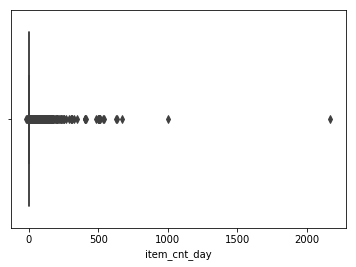

In [4]:
sns.boxplot(x=train_df['item_cnt_day'])

In [5]:
for i in range(1, 10):
    size = train_df[train_df.item_cnt_day.between(i, 10)].shape[0]
    print(f'{i}: {size}')
    
print('----------------------------------------------------------')
    
for i in range(10, 101, 10):
    size = train_df[train_df.item_cnt_day.between(i, 101)].shape[0]
    print(f'{i}: {size}')
    
print('----------------------------------------------------------')

for i in range(100, 2001, 200):
    size = train_df[train_df.item_cnt_day > i].shape[0]
    print(f'{i}: {size}')

1: 2918377
2: 289005
3: 94804
4: 47454
5: 27769
6: 17295
7: 10957
8: 6900
9: 3997
----------------------------------------------------------
10: 11801
20: 3643
30: 1626
40: 789
50: 421
60: 252
70: 147
80: 96
90: 39
100: 16
----------------------------------------------------------
100: 138
300: 23
500: 12
700: 2
900: 2
1100: 1
1300: 1
1500: 1
1700: 1
1900: 1


In [6]:
items_df = pd.read_csv(DATA + 'items.csv')
item_cats_df = pd.read_csv(DATA + 'item_categories.csv')
shops_df = pd.read_csv(DATA + 'shops.csv')

In [7]:
items_df.head()
item_cats_df.head()
shops_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,shop_name,shop_id,city_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,1,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,1,Якутск
2,"Адыгея ТЦ ""Мега""",2,2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,4,Волжский


In [8]:
cities = [
    'Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
    'Жуковский', 'Казань', 'Калуга', 'Коломна', 'Красноярск', 'Курск',
    'Москва', 'Н.Новгород', 'Мытищи', 'Новосибирск', 'РостовНаДону', 'Омск',
    'СПб', 'Самара', 'Сергиев Посад', 'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Чехов', 'Ярославль'
]
pattern = '(' + '|'.join(cities) + ')'
pattern
shops_df['city'] = shops_df.shop_name.str.extract(pattern)

'(Якутск|Адыгея|Балашиха|Волжский|Вологда|Воронеж|Жуковский|Казань|Калуга|Коломна|Красноярск|Курск|Москва|Н.Новгород|Мытищи|Новосибирск|РостовНаДону|Омск|СПб|Самара|Сергиев Посад|Сургут|Томск|Тюмень|Уфа|Химки|Чехов|Ярославль)'

In [9]:
shops_df.city.fillna('-', inplace=True)

In [10]:
cities = shops_df.city.unique()

In [11]:
values = {'city': cities, 'city_id': range(1, len(cities) + 1)}
cities_df = pd.DataFrame.from_dict(values)

In [12]:
shops_df = shops_df.merge(cities_df, how='left', on='city')
shops_df.drop('city', inplace=True, axis=1)

In [13]:
# cities_df.to_csv(DATA + 'cities.csv', index=False)
# shops_df.to_csv(DATA + 'shops.csv', index=False)

In [14]:
shops = {0: 57, 1: 58, 11: 10, 23: 24}

train_df.shop_id.replace(shops, inplace=True)
test_df.shop_id.replace(shops, inplace=True)

train_df.item_cnt_day.clip(0, 20, inplace=True)

In [15]:
sums = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).item_cnt_day.sum()
sums = sums.reset_index()

train_df.drop_duplicates(subset=['date_block_num', 'shop_id', 'item_id'], keep='last', inplace=True)

train_df = train_df.merge(sums, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_df.drop('item_cnt_day_x', inplace=True, axis=1)
train_df.rename({'item_cnt_day_y': 'item_cnt_day'}, inplace=True, axis=1)

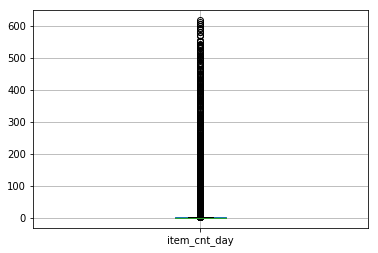

In [16]:
train_df.boxplot(column='item_cnt_day')

In [17]:
# train_df.to_hdf(DATA + 'train_cleaned.h5', key='train', format='table', mode='w')
# test_df.to_hdf(DATA + 'test_cleaned.h5', key='test', format='table', mode='w')

In [28]:
test_df['shop_item'] = test_df.astype(str).shop_id + '_' + test_df.astype(str).item_id
train_df['shop_item'] = train_df.astype(str).shop_id + '_' + train_df.astype(str).item_id

In [29]:
month_df = pd.DataFrame.from_dict({'date_block_num': range(0, 34), 'key': 0})

test_df['key'] = 0
tmp = test_df[['shop_item', 'key']]

tmp = tmp.merge(month_df, how='outer', on='key')

tmp.drop('key', inplace=True, axis=1)

tmp = tmp.merge(train_df, how='left', on=['shop_item', 'date_block_num'])

tmp.drop(['date', 'shop_id', 'item_id'], inplace=True, axis=1)

tmp['shop_id'] = tmp.shop_item.str.split('_').map(lambda x: x[0])
tmp['item_id'] = tmp.shop_item.str.split('_').map(lambda x: x[1])

grouped = tmp[tmp.item_price.notna()].groupby('item_id').item_price.median()

In [30]:
tmp = tmp.merge(grouped.to_frame(), how='left', left_on='item_id', right_index=True)

tmp.loc[tmp.item_price_x.isna(), 'item_price_x'] = tmp.loc[tmp.item_price_x.isna(), 'item_price_y']

tmp.drop('item_price_y', inplace=True, axis=1)
tmp.rename({'item_price_x': 'item_price'}, inplace=True, axis=1)

tmp.item_cnt_day.fillna(0, inplace=True)
tmp.item_cnt_day.clip(0, 20, inplace=True)

tmp.drop('shop_item', inplace=True, axis=1)

tmp.sort_values(by='date_block_num', inplace=True)

tmp.reset_index(inplace=True)

tmp.drop('index', inplace=True, axis=1)

In [31]:
# tmp.to_hdf(DATA + 'train_augmented.h5', key='train', format='table', mode='w')

In [32]:
train_df = tmp

In [33]:
train_df['tmp'] = 0
train_df.loc[train_df.item_cnt_day != 0, 'tmp'] = 1

grouped = train_df.groupby('date_block_num')

tmp = grouped.tmp.sum() / grouped.tmp.count()

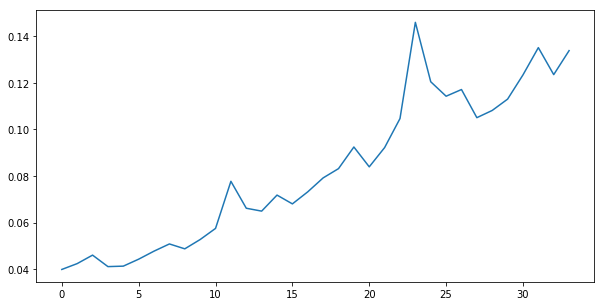

In [34]:
fgr = plt.figure(figsize=(10, 5))
plt.plot(tmp.index.values, tmp.values);

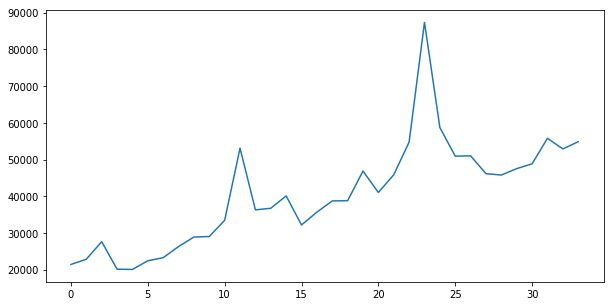

In [35]:
sums = grouped.item_cnt_day.sum()

fgr = plt.figure(figsize=(10, 5))
plt.plot(sums.index.values, sums.values);

Futures generation is omitted due to a lot of code which not always written in good way.

In [2]:
import lightgbm as lgb

from sklearn.model_selection import cross_val_score, TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_hdf(DATA + 'features_v1.h5', key='features')

train_df.shape
train_df.head()

(4712400, 33)

,date_block_num,item_price,item_cnt_day,shop_id,item_id,item_category_id,city_id,item_lag_1,item_lag_3,item_lag_6,...,item_city_lag_12,item_category_city_lag_1,item_category_city_lag_3,item_category_city_lag_6,item_category_city_lag_9,item_category_city_lag_12,item_city_avg,item_category_city_avg,month,days
61200,12,6999.0,0.0,5,3839,24,5,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1,31
61201,12,899.0,0.0,5,6415,23,5,0.000000,0.032258,0.0,...,0.0,1.838710,1.483871,0.258065,0.322581,0.0,0.083333,0.153153,1,31
61202,12,2090.0,0.0,5,5664,3,5,0.032258,0.000000,0.0,...,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.083333,0.107143,1,31
61203,12,2599.0,6.0,5,3734,23,5,0.516129,0.645161,0.0,...,0.0,1.838710,1.483871,0.258065,0.322581,0.0,5.583333,0.153067,1,31
61204,12,599.0,0.0,5,6710,30,5,0.000000,0.000000,0.0,...,0.0,4.806452,3.129032,2.741935,1.838710,0.0,0.000000,0.643995,1,31


In [4]:
y_df = train_df.item_cnt_day
train_df.drop('item_cnt_day', inplace=True, axis=1)

In [5]:
train_df.columns

Index(['date_block_num', 'item_price', 'shop_id', 'item_id',
       'item_category_id', 'city_id', 'item_lag_1', 'item_lag_3', 'item_lag_6',
       'item_lag_9', 'item_lag_12', 'item_category_lag_1',
       'item_category_lag_3', 'item_category_lag_6', 'item_category_lag_9',
       'item_category_lag_12', 'item_avg', 'item_category_avg',
       'item_city_lag_1', 'item_city_lag_3', 'item_city_lag_6',
       'item_city_lag_9', 'item_city_lag_12', 'item_category_city_lag_1',
       'item_category_city_lag_3', 'item_category_city_lag_6',
       'item_category_city_lag_9', 'item_category_city_lag_12',
       'item_city_avg', 'item_category_city_avg', 'month', 'days'],
      dtype='object')

In [6]:
columns = [
    'item_price', 'shop_id', 'item_id', 'item_category_id', 'city_id', 'month', 'days',
    'date_block_num', 'item_lag_1', 'item_lag_3', 'item_lag_6', 'item_lag_9',
    'item_lag_12', 'item_category_lag_1', 'item_category_lag_3',
    'item_category_lag_6', 'item_category_lag_9', 'item_category_lag_12',
    'item_avg', 'item_category_avg', 'item_city_lag_1', 'item_city_lag_3',
    'item_city_lag_6', 'item_city_lag_9', 'item_city_lag_12',
    'item_category_city_lag_1', 'item_category_city_lag_3',
    'item_category_city_lag_6', 'item_category_city_lag_9',
    'item_category_city_lag_12', 'item_city_avg', 'item_category_city_avg'
]

In [7]:
X = train_df[train_df.date_block_num > 23][columns].values
y = y_df[train_df.date_block_num > 23].values

In [8]:
def cross_val_score_lgb(X, y, cv, params, categorical_feature):

    scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=lgb_eval,
            early_stopping_rounds=30,
            verbose_eval=10,
            categorical_feature=categorical_feature)

        y_pred = gbm.predict(X_valid, num_iteration=gbm.best_iteration)
        score = mean_squared_error(y_valid, y_pred)**0.5
        scores.append(score)
        print("RMSE score:", score)

    return gbm, scores

In [9]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'rmse',
    'verbose': 10,
    'num_iterations': 500
}
categorical_columns = list(range(7))
cv = TimeSeriesSplit(n_splits=5)

gbm, scores = cross_val_score_lgb(X, y, cv, params, categorical_columns)

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.807717
[20]	valid_0's rmse: 0.752719
[30]	valid_0's rmse: 0.731221
[40]	valid_0's rmse: 0.718519
[50]	valid_0's rmse: 0.7097
[60]	valid_0's rmse: 0.702782
[70]	valid_0's rmse: 0.699271
[80]	valid_0's rmse: 0.695775
[90]	valid_0's rmse: 0.692892
[100]	valid_0's rmse: 0.689714
[110]	valid_0's rmse: 0.686631
[120]	valid_0's rmse: 0.684439
[130]	valid_0's rmse: 0.681558
[140]	valid_0's rmse: 0.677728
[150]	valid_0's rmse: 0.676515
[160]	valid_0's rmse: 0.674592
[170]	valid_0's rmse: 0.673296
[180]	valid_0's rmse: 0.671837
[190]	valid_0's rmse: 0.670859
[200]	valid_0's rmse: 0.66942
[210]	valid_0's rmse: 0.668813
[220]	valid_0's rmse: 0.66838
[230]	valid_0's rmse: 0.667185
[240]	valid_0's rmse: 0.666335
[250]	valid_0's rmse: 0.665576
[260]	valid_0's rmse: 0.664901
[270]	valid_0's rmse: 0.663988
[280]	valid_0's rmse: 0.663593
[290]	valid_0's rmse: 0.663228
[300]	valid_0's rmse: 0.662281
[310]	valid_0's rmse:

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.642837
[20]	valid_0's rmse: 0.599939
[30]	valid_0's rmse: 0.579649
[40]	valid_0's rmse: 0.569285
[50]	valid_0's rmse: 0.560372
[60]	valid_0's rmse: 0.547434
[70]	valid_0's rmse: 0.54268
[80]	valid_0's rmse: 0.539785
[90]	valid_0's rmse: 0.535338
[100]	valid_0's rmse: 0.53263
[110]	valid_0's rmse: 0.531135
[120]	valid_0's rmse: 0.530417
[130]	valid_0's rmse: 0.528749
[140]	valid_0's rmse: 0.525435
[150]	valid_0's rmse: 0.522541
[160]	valid_0's rmse: 0.521293
[170]	valid_0's rmse: 0.5192
[180]	valid_0's rmse: 0.518007
[190]	valid_0's rmse: 0.517185
[200]	valid_0's rmse: 0.514839
[210]	valid_0's rmse: 0.513123
[220]	valid_0's rmse: 0.511421
[230]	valid_0's rmse: 0.509813
[240]	valid_0's rmse: 0.50747
[250]	valid_0's rmse: 0.506092
[260]	valid_0's rmse: 0.504646
[270]	valid_0's rmse: 0.504176
[280]	valid_0's rmse: 0.503382
[290]	valid_0's rmse: 0.502462
[300]	valid_0's rmse: 0.501495
[310]	valid_0's rmse: 

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.793257
[20]	valid_0's rmse: 0.743659
[30]	valid_0's rmse: 0.724379
[40]	valid_0's rmse: 0.715535
[50]	valid_0's rmse: 0.712142
[60]	valid_0's rmse: 0.707474
[70]	valid_0's rmse: 0.703732
[80]	valid_0's rmse: 0.702653
[90]	valid_0's rmse: 0.70625
[100]	valid_0's rmse: 0.706039
Early stopping, best iteration is:
[74]	valid_0's rmse: 0.70239
RMSE score: 0.6999069503343308


C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 0.778131
[20]	valid_0's rmse: 0.720911
[30]	valid_0's rmse: 0.698001
[40]	valid_0's rmse: 0.6858
[50]	valid_0's rmse: 0.67723
[60]	valid_0's rmse: 0.666357
[70]	valid_0's rmse: 0.662042
[80]	valid_0's rmse: 0.660018
[90]	valid_0's rmse: 0.655808
[100]	valid_0's rmse: 0.653056
[110]	valid_0's rmse: 0.651346
[120]	valid_0's rmse: 0.648372
[130]	valid_0's rmse: 0.645218
[140]	valid_0's rmse: 0.644758
[150]	valid_0's rmse: 0.641106
[160]	valid_0's rmse: 0.641271
[170]	valid_0's rmse: 0.63979
[180]	valid_0's rmse: 0.637948
[190]	valid_0's rmse: 0.636962
[200]	valid_0's rmse: 0.636094
[210]	valid_0's rmse: 0.633755
[220]	valid_0's rmse: 0.633159
[230]	valid_0's rmse: 0.633577
[240]	valid_0's rmse: 0.631769
[250]	valid_0's rmse: 0.631558
[260]	valid_0's rmse: 0.630139
[270]	valid_0's rmse: 0.628307
[280]	valid_0's rmse: 0.628237
[290]	valid_0's rmse: 0.62706
[300]	valid_0's rmse: 0.625087
[310]	valid_0's rmse: 

C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 1, 2, 3, 4, 5, 6]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\kipil\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 30 rounds.
[10]	valid_0's rmse: 1.24441
[20]	valid_0's rmse: 1.15158
[30]	valid_0's rmse: 1.11701
[40]	valid_0's rmse: 1.1024
[50]	valid_0's rmse: 1.08809
[60]	valid_0's rmse: 1.07504
[70]	valid_0's rmse: 1.06569
[80]	valid_0's rmse: 1.067
[90]	valid_0's rmse: 1.06089
[100]	valid_0's rmse: 1.05551
[110]	valid_0's rmse: 1.05384
[120]	valid_0's rmse: 1.05181
[130]	valid_0's rmse: 1.04825
[140]	valid_0's rmse: 1.04313
[150]	valid_0's rmse: 1.04092
[160]	valid_0's rmse: 1.03807
[170]	valid_0's rmse: 1.03716
[180]	valid_0's rmse: 1.03478
[190]	valid_0's rmse: 1.03394
[200]	valid_0's rmse: 1.03116
[210]	valid_0's rmse: 1.03023
[220]	valid_0's rmse: 1.02707
[230]	valid_0's rmse: 1.02477
[240]	valid_0's rmse: 1.02343
[250]	valid_0's rmse: 1.02168
[260]	valid_0's rmse: 1.02035
[270]	valid_0's rmse: 1.01803
[280]	valid_0's rmse: 1.01716
[290]	valid_0's rmse: 1.01531
[300]	valid_0's rmse: 1.01383
[310]	valid_0's rmse: 1.0113
[320]	valid_0's rmse:

In [10]:
scores

[0.6644034323287625,
 0.4910133320176178,
 0.6999069503343308,
 0.6233810142498251,
 0.9889956795947848]

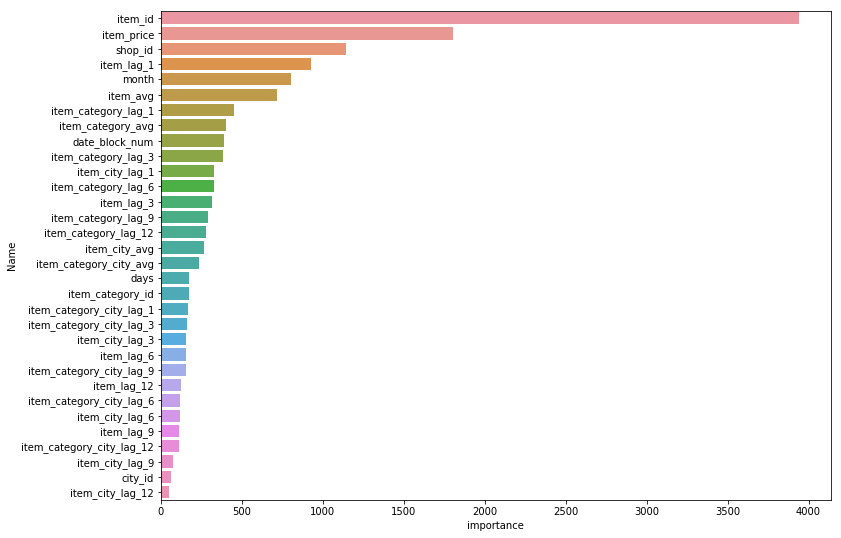

In [11]:
lgbmMetrics = pd.concat([pd.Series(columns), pd.Series(gbm.feature_importance())], axis=1)
lgbmMetrics.columns = ['Name', 'importance']
metrics_sorted = lgbmMetrics.sort_values(by='importance', ascending=False)
g = sns.barplot(x="importance", y="Name", data=metrics_sorted)
g.figure.set_size_inches(12, 9)